In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")  # turn off warnings

## Tutorial

### From effective areas to discovery potentials

The toise package uses parameterized instrument response functions to construct multi-dimensional neutrino effective areas for neutrino detector designs. These effective areas are used to convert neutrino fluxes for signal and background components into event rates in observable bins, and the event rates in turn to derive median sensitivities and discovery potentials for various kinds of astrophysical neutrino fluxes.

### Effective area factory interface

The toise package comes with a few pre-made instrument responses. The easiest way to use these is through the `toise.factory` module. This module keeps track of known instrument configurations, and creates effective areas for them on demand. In this tutorial we will only be looking at diffuse fluxes, so we set the default binning in source opening angle to a single bin:

In [2]:
import numpy
from toise import factory

factory.set_kwargs(psi_bins={k: [0, numpy.pi] for k in ("tracks", "cascades", "radio")})

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


You can of course construct and use arbitrary effective areas. We'll cover that later. Now, you can explicitly call the factory to construct the effective areas for various event classes:

In [3]:
aeffs = factory.get("Fictive-Optical")

This returns a dictionary whose keys are the event classes. Currently there are:

* shadowed_tracks: tracks entering the detector from the outside that pass through the footprint of the surface veto. These have a smaller penetrating muon background than
* unshadowed_tracks: all remaining throughgoing tracks.
* cascades: neutrino interactions inside the fiducial volume (1/2 string spacing inside the outer strings) where the outgoing lepton is a) not a muon, and b) not a tau with a decay length > 300 m.

In [4]:
aeffs.keys()

dict_keys(['shadowed_tracks', 'unshadowed_tracks', 'double_cascades', 'starting_tracks', 'cascades'])

Behind each of these keys is a pair of effective areas, one for neutrinos, and one for penetrating atmospheric muons. Cascades are a special case, as we currently assume that the outer-layer veto completely removes penetrating muons. This is represented by an empty effective area:

In [5]:
print("shadowed_tracks: {}".format(aeffs["shadowed_tracks"]))
print("cascades: {}".format(aeffs["cascades"]))

shadowed_tracks: (<toise.effective_areas.effective_area object at 0x10b2cfb20>, <toise.effective_areas.effective_area object at 0x110026a00>)
cascades: (<toise.effective_areas.effective_area object at 0x11032fc70>, None)


In [6]:
area = aeffs["unshadowed_tracks"][0]
print("area.values.shape: {}".format(area.values.shape))
print("{}: 6 bins (1 per type)".format(area.dimensions[0]))
for label, edges in zip(area.dimensions[1:], area.bin_edges):
    print("{}: [{}, ..., {}]".format(label, edges[0], edges[-1]))

area.values.shape: (6, 100, 20, 100, 2)
type: 6 bins (1 per type)
true_energy: [10.0, ..., 100000000000.0]
true_zenith_band: [-1.0, ..., 1.0]
reco_energy: [10.0, ..., 100000000000.0]
reco_psi: [0.0, ..., inf]


## Flux components

To predict the sensitivity of a given detector configuration (exposure, i.e. effective area and livetime) to a neutrino emission scenario, we have to calculate event rates. This is where flux components come in. There are a number of them available in `toise.diffuse` and `toise.pointsource`. The diffuse versions predict event rates integrated over zenith angle bins, while event rates from point source fluxes are divided into rings centered on the putative source position.

As an example, let's construct a conventional atmospheric neutrino background (Honda 2006 + H3a). Like all components, it has an `expectations` attribute that returns a dictionary of event rates, in this case divided into 20 bins of cos(zenith) (as we requested when we constructed the effective area) and 100 bins of reconstructed energy proxy. For convenience we choose a year of livetime. Below is a plot of the event rate per energy proxy bin compared to an isotropic, $E^2\Phi = 10^{-8} \, {\rm GeV \, cm^{-2} \, sr^{-1} \, s^{-1}}$ per flavor flux for horizontal tracks.

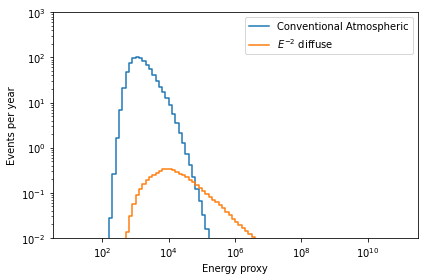

In [7]:
from toise import diffuse, plotting

conventional = diffuse.AtmosphericNu.conventional(area, livetime=1)
astro = diffuse.DiffuseAstro(area, livetime=1)
edges = area.bin_edges[area.dimensions.index("reco_energy") - 1]

fig, ax = plt.subplots()
ax.plot(
    *plotting.stepped_path(edges, conventional.expectations[10, :]),
    label="Conventional Atmospheric"
)
ax.plot(
    *plotting.stepped_path(edges, astro.expectations()[10, :]),
    label=r"$E^{-2}$ diffuse"
)
plt.legend()
plt.loglog()
ax.set_ylim(1e-2, 1e3)
ax.set_ylabel("Events per year")
ax.set_xlabel("Energy proxy")
plt.tight_layout()
del fig, ax

## Multiple flux components (bundles)

A real analysis will use multiple detection channels in different detectors (e.g. N years of detector 1 plus M years of detector 2), each of which is represented by a different effective area. You can create event rate predictions for such a collection of effective areas by writing a factory function like the following:

In [8]:
from toise import diffuse, multillh, surface_veto


def make_components(aeffs):
    aeff, muon_aeff = aeffs

    atmo = diffuse.AtmosphericNu.conventional(
        aeff, 1
    )
    atmo.prior = lambda v, **kwargs: -((v - 1) ** 2) / (2 * 0.1**2)
    prompt = diffuse.AtmosphericNu.prompt(aeff, 1)
    prompt.min = 0.5
    prompt.max = 3.0
    astro = diffuse.DiffuseAstro(aeff, 1)
    astro.seed = 2.0

    if muon_aeff is None:
        muon = diffuse.NullComponent(aeff)
    else:
        muon = surface_veto.MuonBundleBackground(muon_aeff, 1)

    return dict(atmo=atmo, prompt=prompt, astro=astro, muon=muon)

    return components

`factory.component_bundle()` uses this factory function to construct components that predict event rates in all detectors and detection channels for the given combination of livetimes (here, 15 years of a fictive detector for simplicity)

In [9]:
bundle = factory.component_bundle({"Fictive-Optical": 15}, make_components)
components = bundle.get_components()
components

{'atmo': <toise.multillh.Combination at 0x15c7daf10>,
 'astro': <toise.multillh.Combination at 0x15c7daa30>,
 'muon': <toise.multillh.Combination at 0x15c7da9d0>,
 'prompt': <toise.multillh.Combination at 0x15c7da6d0>}

## Calculating a sensitivity

You can use these to construct a likelihood and predict sensitivities and discovery potentials. As an illustration, let's calculate the sensitivity (median 90% upper limit assuming there is no actual signal) for the normalization of an E^-2 isotropic equal-flavor flux. To do this exactly, you would draw realizations of the data Poisson-distributed around the mean event rate in each bin, fit for the normalization of the E^-2 component, derive an upper limit, and take the median upper limit from the population of realizations. Here we take two shortcuts: 1) we construct a special dataset, called the "Asimov dataset," where the observed event rates are replaced by their exact means, and 2) we assume that the null test statistic (TS) is chi^2 distributed. 1) is okay because the TS derived from the Asimov LLH is the same as the median of TSes from Poisson-sampled realizations, and 2) is okay as long as the event rate in the bins that provide most of the TS is sufficiently large (in practice, >= 10 per bin). To calculate sensitivity, we create pseudodata where there is no contribution at all from the E^-2 component:

In [10]:
llh = multillh.asimov_llh(bundle.get_components(), astro=0)

Now, let's actually calculate a sensitivity. We do this by calculating the TS between the best fit (astro=0) and a given normalization, and finding the point where this crosses ~2.705 (90% CL for 1 degree of freedom):

In [11]:
from scipy.optimize import bisect
from scipy import stats

# test statistic between astro = f and astro = 0
ts = lambda f: -2 * (llh.llh(**llh.fit(astro=f)) - llh.llh(**llh.fit(astro=0)))
# fit for \Delta TS = 2.705 (90% CL for 1 degree of freedom)
critical_ts = stats.chi2(1).ppf(0.9)
limit = bisect(lambda f: ts(f) - critical_ts, 0, 1)
limit

0.007883191750806873

In other words, if the signal were not real, 15 years of this fictive detector would constrain the normalization of an E^-2 component to ~1/1000 of the flux level we think we see. We can also plot a profile likelihood for comparison.

Text(0.5, 0, 'Astro flux normalization')

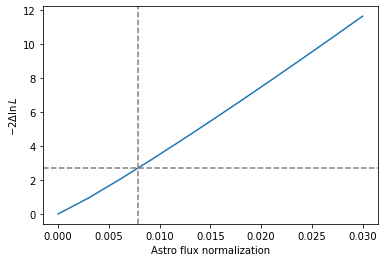

In [12]:
# also plot a profile likelihood
x = numpy.linspace(0.0, 3e-2, 11)
prof = llh.profile1d("astro", x)
ts = -2 * (prof["LLH"] - numpy.nanmax(prof["LLH"]))

plt.plot(x, ts)
plt.axvline(limit, ls="--", color="grey")
plt.axhline(critical_ts, ls="--", color="grey")

plt.ylabel("$-2\Delta \ln L$")
plt.xlabel("Astro flux normalization")

This component-construction and limit-setting procedure is automated for a few common cases in the `figures_of_merit` module. Here, for example, we make a figure-of-merit object for testing sensitivity to the Ahlers et al GZK flux:

In [13]:
from toise import figures_of_merit

fom = figures_of_merit.GZK({"Fictive-Optical": 15})

There are several different figures of merit we could ask for: an upper limit (sensitivity), $5\sigma$ discovery potential, or a Feldman-Cousins upper limit (more useful in the no-background case typical of UHE searches). These can be either integrated over the entire energy range of the signal, or divided into energy bins. For example, we can calculate a model-dependent upper limit using the full energy range:

In [14]:
fom.benchmark(figures_of_merit.TOT.ul)

INFO:root:ns: 6.2 nb: 3.6e+04


(2.6033750243604334, 6.1947053425974445, 36285.34227237676)

It's also useful to construct a differential limit, where the neutrino flux is only considered in smaller energy ranges. For example, let's construct a limit over single decades. Note that the limit is returned in units of the Ahlers et al flux, so some extra work would be required to put it in standard units.

In [15]:
fulldecade = fom.benchmark(figures_of_merit.DIFF.ul, decades=1)
halfdecade = fom.benchmark(figures_of_merit.DIFF.ul, decades=0.5)

INFO:root:ns: 17 nb: 3.6e+04
INFO:root:ns: 25 nb: 3.6e+04
INFO:root:ns: 56 nb: 3.6e+04
INFO:root:ns: 1.2e+02 nb: 3.6e+04
INFO:root:ns: 90 nb: 3.6e+04
INFO:root:ns: 32 nb: 3.6e+04
INFO:root:ns: 13 nb: 3.6e+04
INFO:root:ns: 5.9 nb: 3.6e+04
INFO:root:ns: 3.3 nb: 3.6e+04
INFO:root:ns: 2.3 nb: 3.6e+04
INFO:root:ns: 1.5 nb: 3.6e+04
INFO:root:ns: 16 nb: 3.6e+04
INFO:root:ns: 17 nb: 3.6e+04
INFO:root:ns: 19 nb: 3.6e+04
INFO:root:ns: 25 nb: 3.6e+04
INFO:root:ns: 38 nb: 3.6e+04
INFO:root:ns: 59 nb: 3.6e+04
INFO:root:ns: 85 nb: 3.6e+04
INFO:root:ns: 1e+02 nb: 3.6e+04
INFO:root:ns: 88 nb: 3.6e+04
INFO:root:ns: 57 nb: 3.6e+04
INFO:root:ns: 35 nb: 3.6e+04
INFO:root:ns: 20 nb: 3.6e+04
INFO:root:ns: 15 nb: 3.6e+04
INFO:root:ns: 9.4 nb: 3.6e+04
INFO:root:ns: 6.4 nb: 3.6e+04
INFO:root:ns: 4.5 nb: 3.6e+04
INFO:root:ns: 3.4 nb: 3.6e+04
INFO:root:ns: 2.8 nb: 3.6e+04
INFO:root:ns: 2.4 nb: 3.6e+04
INFO:root:ns: 2.1 nb: 3.6e+04
INFO:root:ns: 1.5 nb: 3.6e+04
INFO:root:ns: 1.4 nb: 3.6e+04


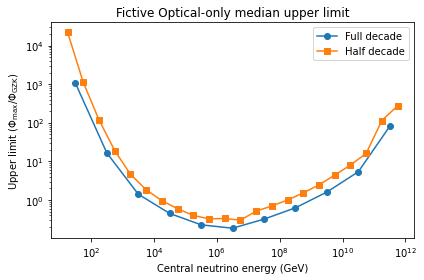

In [16]:
fig, ax = plt.subplots()
ax.loglog(*fulldecade[:2], marker="o", label="Full decade")
ax.loglog(*halfdecade[:2], marker="s", label="Half decade")
ax.set_ylabel(r"Upper limit ($\Phi_{\max}/\Phi_{\rm GZK}$)")
ax.set_xlabel(r"Central neutrino energy (GeV)")
ax.legend()
plt.title("Fictive Optical-only median upper limit")
plt.tight_layout()
del fig, ax

Now we can see how adding a radio array might boost sensitivity. For purposes of illustration we will use equal livetimes, but you could adjust these to account for duty cycles, construction schedule differences, etc.

In [17]:
fom_with_radio = figures_of_merit.GZK({"Fictive-Optical": 15, "Fictive-Radio": 15})

In [18]:
fulldecade_withradio = fom_with_radio.benchmark(figures_of_merit.DIFF.ul, decades=1)
halfdecade_withradio = fom_with_radio.benchmark(figures_of_merit.DIFF.ul, decades=0.5)

INFO:root:ns: 17 nb: 3.6e+04
INFO:root:ns: 25 nb: 3.6e+04
INFO:root:ns: 56 nb: 3.6e+04
INFO:root:ns: 1.1e+02 nb: 3.6e+04
INFO:root:ns: 88 nb: 3.6e+04
INFO:root:ns: 32 nb: 3.6e+04
INFO:root:ns: 13 nb: 3.6e+04
INFO:root:ns: 8.5 nb: 3.6e+04
INFO:root:ns: 6.2 nb: 3.6e+04
INFO:root:ns: 4 nb: 3.6e+04
INFO:root:ns: 2.6 nb: 3.6e+04
INFO:root:ns: 16 nb: 3.6e+04
INFO:root:ns: 17 nb: 3.6e+04
INFO:root:ns: 19 nb: 3.6e+04
INFO:root:ns: 25 nb: 3.6e+04
INFO:root:ns: 38 nb: 3.6e+04
INFO:root:ns: 58 nb: 3.6e+04
INFO:root:ns: 84 nb: 3.6e+04
INFO:root:ns: 1e+02 nb: 3.6e+04
INFO:root:ns: 86 nb: 3.6e+04
INFO:root:ns: 57 nb: 3.6e+04
INFO:root:ns: 35 nb: 3.6e+04
INFO:root:ns: 20 nb: 3.6e+04
INFO:root:ns: 14 nb: 3.6e+04
INFO:root:ns: 9.3 nb: 3.6e+04
INFO:root:ns: 7.8 nb: 3.6e+04
INFO:root:ns: 6.9 nb: 3.6e+04
INFO:root:ns: 6 nb: 3.6e+04
INFO:root:ns: 4.9 nb: 3.6e+04
INFO:root:ns: 4 nb: 3.6e+04
INFO:root:ns: 3.3 nb: 3.6e+04
INFO:root:ns: 2.7 nb: 3.6e+04
INFO:root:ns: 2.3 nb: 3.6e+04


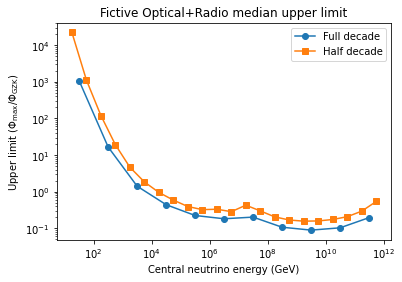

In [19]:
fig, ax = plt.subplots()
ax.loglog(*fulldecade_withradio[:2], marker="o", label="Full decade")
ax.loglog(*halfdecade_withradio[:2], marker="s", label="Half decade")
ax.set_ylabel(r"Upper limit ($\Phi_{\max}/\Phi_{\rm GZK}$)")
ax.set_xlabel(r"Central neutrino energy (GeV)")
ax.legend()
plt.title("Fictive Optical+Radio median upper limit")
del fig, ax

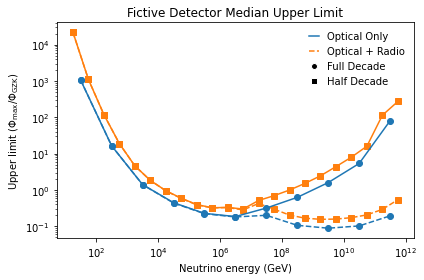

In [21]:
# here, we plot them together, just to get the full effect
# this is also a plot in the paper

from matplotlib import style

style.use("../../figures/toise.mplstyle")

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots()

ax.loglog(*halfdecade[:2], marker="s", color="C1", label="Half decade")
ax.loglog(*halfdecade_withradio[:2], "s--", color="C1")
ax.loglog(*fulldecade[:2], marker="o", color="C0", label="Full decade")
ax.loglog(*fulldecade_withradio[:2], "o--", color="C0")

ax.set_ylabel(r"Upper limit ($\Phi_{\max}/\Phi_{\rm GZK}$)")
ax.set_xlabel(r"Neutrino energy (GeV)")
ax.set_title("Fictive Detector Median Upper Limit")

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([-10], [-10], color="C0", label="Optical Only"),
    Line2D([-10], [-10], color="C1", linestyle="--", label="Optical + Radio"),
    Line2D(
        [-10], [-10], marker="o", color="w", markerfacecolor="k", label="Full Decade"
    ),
    Line2D(
        [-10], [-10], marker="s", color="w", markerfacecolor="k", label="Half Decade"
    ),
]
ax.legend(handles=legend_elements)

plt.tight_layout()
fig.savefig("UHELimit_wradio.pdf")